In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import os
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings("ignore")


In [38]:
# loading data
os.chdir('C:/Users/Danil/Desktop/School/UChicago/Classes/Spring 2023/Time_Series/Project/Data')
data = pd.read_csv('XGboost_data.csv')
data

,week,mean_travel_time,avg_temp,avg_humidity,holiday
0,2015-12-27,23.616667,55.062500,26.263333,False
1,2016-01-03,28.975000,54.415094,73.246792,True
2,2016-01-10,29.425000,55.858953,73.944084,True
3,2016-01-17,28.637500,58.247414,85.364828,False
4,2016-01-24,33.570833,59.434831,56.483034,True
...,...,...,...,...,...
213,2020-01-26,29.806667,63.399888,47.115225,True
214,2020-02-02,28.710000,56.322623,48.937268,True
215,2020-02-09,30.190000,58.876313,60.706089,False
216,2020-02-16,28.413333,59.851374,73.167441,False


In [39]:
# loading the average_travel_time for each route
avg_trav_time = pd.read_csv('Avg_Travel_Time_50_Routes.csv')
avg_trav_time

,week,travel_time
0,12/27/15,24.738444
1,1/3/16,27.119342
2,1/10/16,29.542540
3,1/17/16,29.085661
4,1/24/16,31.035735
...,...,...
213,1/26/20,29.597266
214,2/2/20,28.685360
215,2/9/20,30.140697
216,2/16/20,28.328776


In [40]:
# substitute the mean_travel_time
data['mean_travel_time']=avg_trav_time['travel_time']
data

,week,mean_travel_time,avg_temp,avg_humidity,holiday
0,2015-12-27,24.738444,55.062500,26.263333,False
1,2016-01-03,27.119342,54.415094,73.246792,True
2,2016-01-10,29.542540,55.858953,73.944084,True
3,2016-01-17,29.085661,58.247414,85.364828,False
4,2016-01-24,31.035735,59.434831,56.483034,True
...,...,...,...,...,...
213,2020-01-26,29.597266,63.399888,47.115225,True
214,2020-02-02,28.685360,56.322623,48.937268,True
215,2020-02-09,30.140697,58.876313,60.706089,False
216,2020-02-16,28.328776,59.851374,73.167441,False


In [41]:
# check for stationarity
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(data['mean_travel_time'])
adf_pvalue = adf_result[1]
print("Augmented Dickey-Fuller Test:")
print(f"P-value: {adf_pvalue}")

# Perform Kwiatkowski-Phillips-Schmidt-Shin test
kpss_result = kpss(data['mean_travel_time'])
kpss_pvalue = kpss_result[1]
print("\nKwiatkowski-Phillips-Schmidt-Shin Test:")
print(f"P-value: {kpss_pvalue}")

# Stationarity?
if (kpss_pvalue or adf_pvalue)>.05:
    print('\nThe data is non-statinary')
else:
    print('\nThe data is stationary')

Augmented Dickey-Fuller Test:
P-value: 0.04930506605535676

Kwiatkowski-Phillips-Schmidt-Shin Test:
P-value: 0.1

The data is non-statinary


In [42]:
# factorize the binary catgorical feature
data['holiday'] = pd.factorize(data['holiday'])[0]
data.head()

,week,mean_travel_time,avg_temp,avg_humidity,holiday
0,2015-12-27,24.738444,55.062500,26.263333,0
1,2016-01-03,27.119342,54.415094,73.246792,1
2,2016-01-10,29.542540,55.858953,73.944084,1
3,2016-01-17,29.085661,58.247414,85.364828,0
4,2016-01-24,31.035735,59.434831,56.483034,1


In [55]:
# assigning dependent and independent vars
predictors = ['avg_temp','avg_humidity','holiday']
target = 'mean_travel_time'

In [56]:
# train test split (52 weeks train split)
train_data = data[:184]
test_data = data[184:]
X_train, y_train, X_test, y_test = train_data[predictors], train_data[target], test_data[predictors], test_data[target]
print(f'Total observaions: {len(train_data)+len(test_data)} \nTrain data observations: {len(train_data)} \nTest data observations: {len(test_data)}')

Total observaions: 218 
Train data observations: 184 
Test data observations: 34


In [59]:
# XBGRegressor Model with RandomizedSearchCV
xgb_model = XGBRegressor()

# parameter grid for RandomizedSearchCV
param_grid = {"n_estimators": [100, 500, 700, 1000],"learning_rate": [0.01, 0.1, 0.5, 1],"max_depth": [3, 5, 7, 10],"gamma": [0, 0.1, 0.5, 1]}

# RandomizedSearchCV finding the best hyperparameters with 10-fold cross-validation
xgb_randser = RandomizedSearchCV(estimator=xgb_model,param_distributions=param_grid,n_iter=50,scoring="neg_mean_squared_error",cv=10,n_jobs=-1,random_state=10)

# Fitting the model with RandSearch CV
xgb_randser.fit(X_train, y_train)


RandomizedSearchCV(cv=10,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate...
                                          min_child_weight=None, missing=nan,
                             

In [60]:
# Fetching the model with the best parameters
best_xgb_model = xgb_randser.best_estimator_
print(best_xgb_model)

# Predict y_pred using the model with the best parameters
y_pred = best_xgb_model.predict(X_test)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


In [61]:
# predictions vs y_test
test_data = test_data.reset_index().drop('index', axis=1)
test_data['predictions'] = pd.Series(y_pred)
pred_col = test_data.pop('predictions')
test_data.insert(2,'predictions',pred_col)
test_data

,week,mean_travel_time,predictions,avg_temp,avg_humidity,holiday
0,2019-07-07,31.928111,32.524174,67.397730,76.187622,1
1,2019-07-14,32.087142,32.869995,67.187245,79.817194,1
2,2019-07-21,32.331827,32.026512,70.852229,73.848629,1
3,2019-07-28,32.035939,32.882111,67.654545,82.627727,1
4,2019-08-04,31.993016,31.955585,66.070254,85.565178,1
5,2019-08-11,32.349304,32.879005,66.395429,83.010000,1
6,2019-08-18,33.146040,32.624542,71.604865,70.743946,1
7,2019-08-25,31.982715,30.992846,73.749180,73.131858,0
8,2019-09-01,29.909167,31.452261,75.541695,69.198757,0
9,2019-09-08,31.724879,32.635750,72.345574,68.872459,1


In [62]:
# convert predictions to CSV
test_data['predictions'].to_csv('y_pred.csv', index=False)

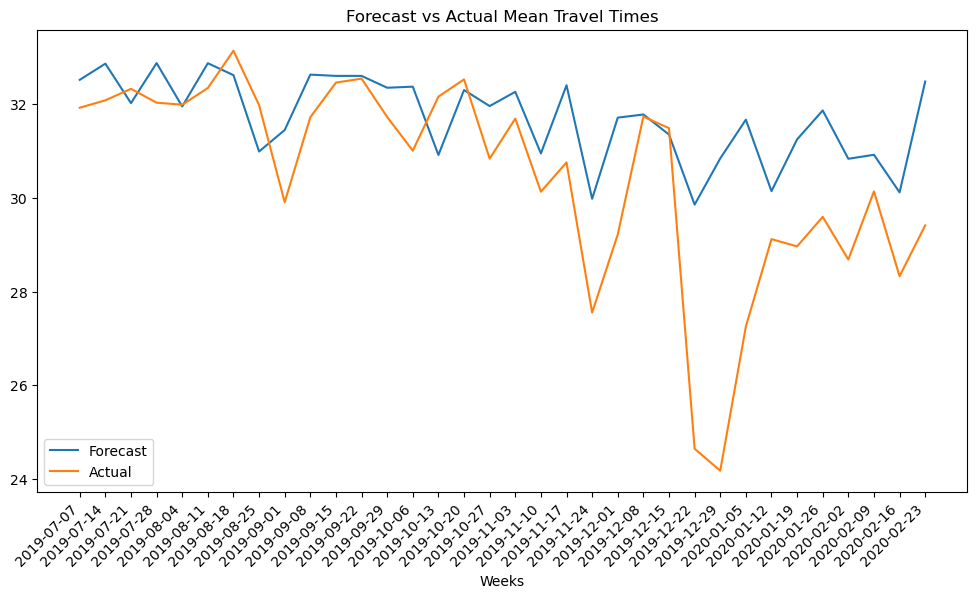

In [63]:
# predictions vs y_test plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test_data['week'], test_data['predictions'], label='Forecast')
ax.plot(test_data['week'], test_data['mean_travel_time'], label='Actual')
ax.legend()
ax.set_xlabel('Weeks')
ax.set_xticklabels(test_data['week'], rotation=45, ha='right')
ax.set_title('Forecast vs Actual Mean Travel Times')
plt.show()

In [64]:
# Top features
important_features = X_train.columns[best_xgb_model.feature_importances_.argsort()[::-1]] # sorting in decending order and select the top most important features

print('Most Important Features in Order:')
for num,i in enumerate(important_features):
    print(num+1,i)

Most Important Features in Order:
1 holiday
2 avg_temp
3 avg_humidity


In [65]:
# Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", round(mse,4))
print("Root Mean squared error:", round(np.sqrt(mse),4))

Mean squared error: 4.357
Root Mean squared error: 2.0874
